In [26]:
#loading dependencies
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
print("Done")

Done


In [27]:
#tranforms defined for training for data augmentation
#introducing random flips and rotation for spatial and rotational invariance in the CNN
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                transforms.RandomRotation(10), 
                                transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform = transform_train)
test_data = datasets.CIFAR10('data', train=False,
                              download=True, transform = transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
#making data loaders
valid_size = 0.1
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64)


# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [29]:
#check for GPU(cuda)
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("Training with GPU")
else:
    print("Training with CPU")

Training with GPU


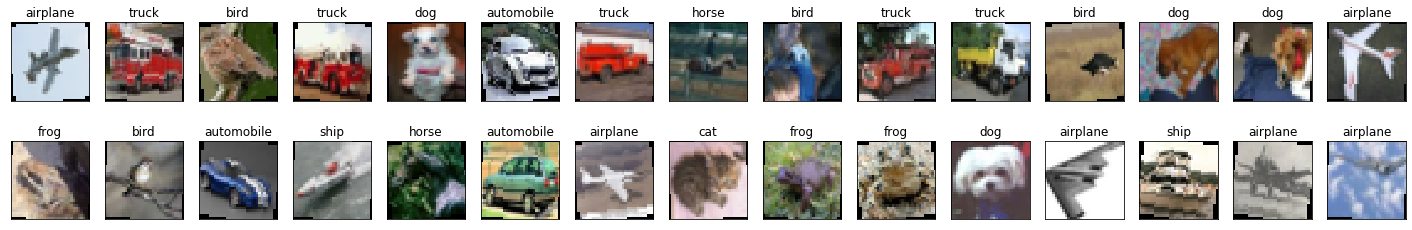

In [30]:
#viewing the images with their labels 
import matplotlib.pyplot as plt
%matplotlib inline
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(30):
    ax = fig.add_subplot(2, 30/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose((images[idx]), (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [48]:
#Defining the model architecture
import torch.nn as nn
import torch.nn.functional as F
class my_cnn(nn.Module):
    def __init__(self):
        super(my_cnn, self).__init__()
        self.Conv1 = nn.Conv2d(3, 16, 3, padding = 1)            #convolutions
        self.Conv2 = nn.Conv2d(16, 32, 3, padding = 1)             
        self.Conv3 = nn.Conv2d(32, 64, 3, padding = 1)            
        self.Conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)                           #pooling layer
        self.fc1 = nn.Linear(128*8*8, 512)                        #fully connected(Dense) layers
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        self.drop = nn.Dropout(p=0.25)                           #dropout layer
        
    def forward(self, x):                                        #feed forward
        x = F.relu(self.Conv1(x))
        x = F.relu(self.Conv2(x))
        x = self.pool(x)
        x = F.relu(self.Conv3(x))
        x = F.relu(self.Conv4(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 8 * 8)                               #flattening
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
model = my_cnn()
if train_on_gpu:
    model.cuda()
print(model)

my_cnn(
  (Conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
)


In [49]:
#defining optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [50]:
epochs = 30  #number of epochs
valid_loss_min = np.Inf  #defining minimum validation loss
train_losses = []
valid_losses = []
for e in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()                                          #training mode
    for images, labels in train_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()                              #deleting previous gradient
        logits = model(images)                            
        loss = criterion(logits, labels) 
        loss.backward()
        optimizer.step()                                   #step in training
        train_loss += loss.item()*images.size()[0]
    train_loss = train_loss/len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()                                           #evaluation mode (NO DROPOUT)
    for images, labels in valid_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
                                                            
        logits = model(images)
        loss = criterion(logits, labels)                   
        valid_loss += loss.item()*images.size()[0]         
    model.train()                                          #training mode
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'cnn_cifar10.pt')   #saving the model with least validation loss
    valid_loss = valid_loss/len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss, valid_loss))    

Epoch: 0 	Training Loss: 2.072584 	Validation Loss: 0.230129
Epoch: 1 	Training Loss: 2.068764 	Validation Loss: 0.229233
Epoch: 2 	Training Loss: 2.012966 	Validation Loss: 0.214021
Epoch: 3 	Training Loss: 1.848415 	Validation Loss: 0.234496
Epoch: 4 	Training Loss: 1.747235 	Validation Loss: 0.184965
Epoch: 5 	Training Loss: 1.657115 	Validation Loss: 0.184168
Epoch: 6 	Training Loss: 1.586465 	Validation Loss: 0.173296
Epoch: 7 	Training Loss: 1.524009 	Validation Loss: 0.228291
Epoch: 8 	Training Loss: 1.473742 	Validation Loss: 0.162877
Epoch: 9 	Training Loss: 1.430872 	Validation Loss: 0.164154
Epoch: 10 	Training Loss: 1.385655 	Validation Loss: 0.162922
Epoch: 11 	Training Loss: 1.344623 	Validation Loss: 0.155202
Epoch: 12 	Training Loss: 1.309488 	Validation Loss: 0.149168
Epoch: 13 	Training Loss: 1.278137 	Validation Loss: 0.135221
Epoch: 14 	Training Loss: 1.245239 	Validation Loss: 0.150863
Epoch: 15 	Training Loss: 1.219073 	Validation Loss: 0.136241
Epoch: 16 	Trainin

Text(0.5, 1.0, 'Training Loss')

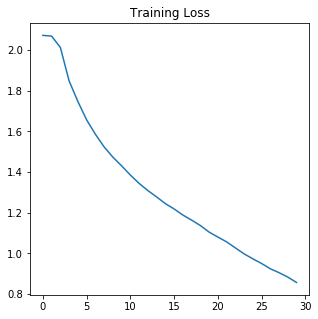

In [51]:
#visualizing training loss over epochs
plt.figure(figsize = (5,5))
plt.plot(train_losses) 
plt.title("Training Loss")

Text(0.5, 1.0, 'Validation Loss')

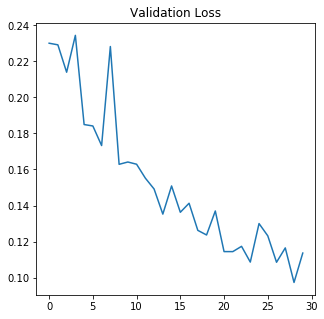

In [52]:
#visualizing validation loss over epochs
plt.figure(figsize = (5,5))          
plt.plot(valid_losses)
plt.title("Validation Loss")

In [53]:
#loading the model with minimum validation loss
model.load_state_dict(torch.load('cnn_cifar10.pt'))

<All keys matched successfully>

In [54]:
#testing the model
test_loss = 0.0
class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]
model.eval()                                                        #evaluation mode
for batch_idx, (images, labels) in enumerate(test_loader):
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
        logits = model(images)
        loss = criterion(logits, labels)
        test_loss += loss.item()*images.size(0)
        pred_prob = F.softmax(logits)                               #finding predicted probabilities
        _, predicted_class = pred_prob.max(1)                       #finding classes with max predicted probability
        correct_tensor = predicted_class.eq(labels.data.view_as(predicted_class))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
        batch_size = labels.size(0)
        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):                                                              #accuracy in each class
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (                           #total accuracy
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

C:\Users\sachd\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Test Loss: 1.112509

Test Accuracy of airplane: 64% (645/1000)
Test Accuracy of automobile: 71% (715/1000)
Test Accuracy of  bird: 46% (463/1000)
Test Accuracy of   cat: 30% (300/1000)
Test Accuracy of  deer: 83% (834/1000)
Test Accuracy of   dog: 52% (527/1000)
Test Accuracy of  frog: 68% (685/1000)
Test Accuracy of horse: 66% (662/1000)
Test Accuracy of  ship: 74% (744/1000)
Test Accuracy of truck: 64% (647/1000)

Test Accuracy (Overall): 62% (6222/10000)


C:\Users\sachd\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


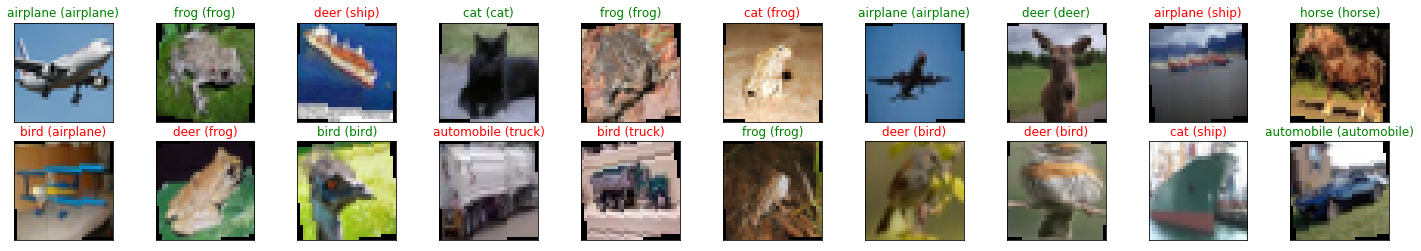

In [64]:
#visualizing the results
images, labels = next(iter(train_loader))
if train_on_gpu:
    images = images.cuda()
logits = model(images)
pred_prob = F.softmax(logits)
_, predicted_class = pred_prob.max(1)
preds = np.squeeze(predicted_class.numpy()) if not train_on_gpu else np.squeeze(predicted_class.cpu().numpy())
fig = plt.figure(figsize=(25, 4))
images = images.cpu()
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose((images[idx]), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))